In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d29b927f-db5c-99f9-b0ca-0351ec9161a1)


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 24 06:42:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
print( f"Python {sys.version}\n" )

import os

import numpy as np
print( f"NumPy {np.__version__}\n" )

import pandas as pd
print( f"Pandas {pd.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

NumPy 1.23.5

Pandas 1.5.3

Matplotlib 3.7.1

TensorFlow 2.14.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


**LOAD DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/datasets/data.zip"

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: data/planes/drone/00000126.jpg  
  inflating: __MACOSX/data/planes/drone/._00000126.jpg  
  inflating: data/planes/drone/00000132.jpg  
  inflating: __MACOSX/data/planes/drone/._00000132.jpg  
  inflating: data/planes/drone/00000318.png  
  inflating: __MACOSX/data/planes/drone/._00000318.png  
  inflating: data/planes/drone/00000683.jpg  
  inflating: __MACOSX/data/planes/drone/._00000683.jpg  
  inflating: data/planes/drone/00000708.jpg  
  inflating: __MACOSX/data/planes/drone/._00000708.jpg  
  inflating: data/planes/drone/00000087.jpeg  
  inflating: __MACOSX/data/planes/drone/._00000087.jpeg  
  inflating: data/planes/drone/00000052.jpg  
  inflating: __MACOSX/data/planes/drone/._00000052.jpg  
  inflating: data/planes/drone/00000046.jpg  
  inflating: __MACOSX/data/planes/drone/._00000046.jpg  
  inflating: data/planes/drone/00000720.jpg  
  inflating: __MACOSX/data/planes/drone/._00000720.jpg  
  inflating: d

In [ ]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
# np.random.seed(1234)
# tf.random.set_seed(5678)

In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00


In [ ]:
import wandb
print(f'WandB {wandb.__version__}')

WandB 0.15.12


In [ ]:
!pip install python-dotenv

In [ ]:
# Choose how you want to use WandB

menu = f"Do you have an environment variable named 'WANDB_API_KEY' stored in .env file?\nYour answer (y/n): "
while True:
  choice = input(menu).lower().strip()

  if choice == 'y':
    # Load 'WANDB_API_KEY' from the ".env" file
    from dotenv import load_dotenv
    load_dotenv('/content/env')
    WANDB_API_KEY = os.getenv('WANDB_API_KEY')
    # print(WANDB_API_KEY)
    # Login with your WandB account
    wandb.login(key=WANDB_API_KEY)
    break

  elif choice == 'n':
    # Login as anonymous (no need for API key)
    wandb.login(anonymous='allow')
    break

  else:
    print('Invalid input. Try again.\n')

Do you have an environment variable named 'WANDB_API_KEY' stored in .env file?
Your answer (y/n): y


wandb: Currently logged in as: mrravit (deep-a). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import os
import cv2
import numpy as np

# ตั้งค่าพารามิเตอร์
dataset_folder = "/content/data/planes"
img_size = (224, 224)  # ขนาดที่คุณต้องการ resize รูป

x_train = []
y_train = []

# วนลูปตามโฟลเดอร์ย่อยภายในโฟลเดอร์ planes
for class_folder in os.listdir(dataset_folder):
    class_path = os.path.join(dataset_folder, class_folder)

    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            # อ่านรูปภาพ
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)

            # Check if the image was loaded successfully
            if img is None:
                print(f"Warning: Image not loaded for file: {img_path}")
                continue

            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert จาก BGR เป็น RGB
            img = cv2.resize(img, img_size)

            x_train.append(img)
            y_train.append(class_folder)  # ใช้ชื่อโฟลเดอร์เป็น label



**CONVERT DATA**

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(3853, 224, 224, 3)
(3853,)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(x_train, test_size = 0.2, random_state = 1)
y_train, y_test = train_test_split(y_train, test_size = 0.2, random_state = 1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3082, 224, 224, 3)
(3082,)
(771, 224, 224, 3)
(771,)


In [ ]:
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(3082, 224, 224, 3) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=<U15 , shape=(3082,) , min=drone , max=rocket
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(771, 224, 224, 3) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=<U15 , shape=(771,) , min=drone , max=rocket


In [ ]:
unique_labels = np.unique(y_train)
label_to_int = {label: i for i, label in enumerate(unique_labels)}

y_train = np.array([label_to_int[label] for label in y_train])
y_test = np.array([label_to_int[label] for label in y_test])

In [ ]:
x_train = x_train.astype('uint8')
x_test = x_test.astype('uint8')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(3082, 224, 224, 3) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(3082,) , min=0.0 , max=4.0
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(771, 224, 224, 3) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(771,) , min=0.0 , max=4.0


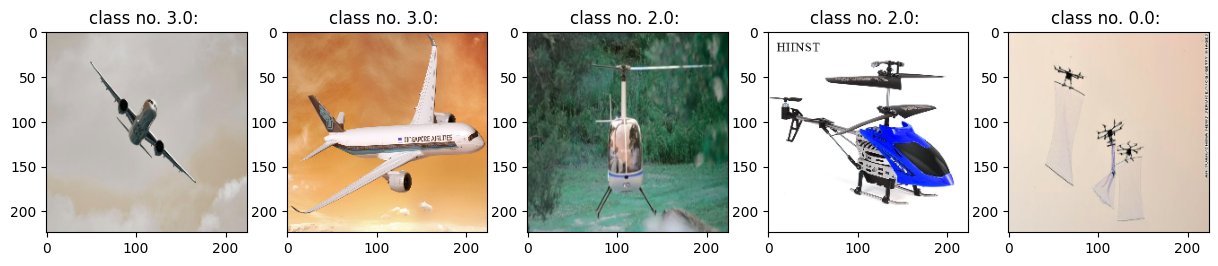

In [ ]:
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(150 + 1 + i).set_title( f"class no. {y_train[i]}: " )
    plt.imshow( x_train[i] )
    #plt.axis( "off" )
plt.show()

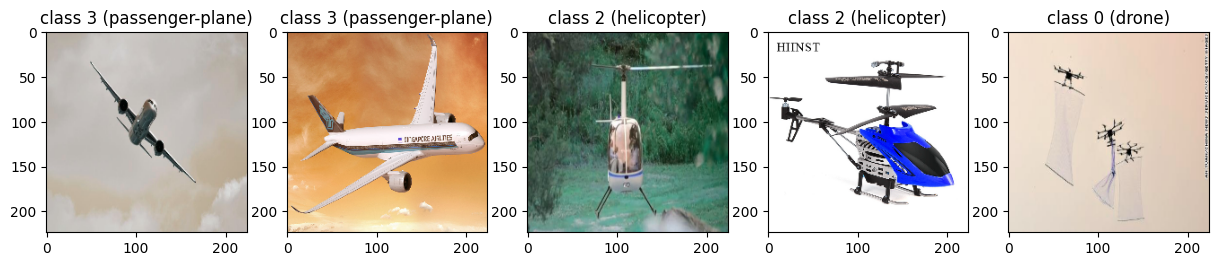

In [ ]:
#visualize the first 5 image of x_train
label = ['drone', 'fighter-jet', 'helicopter', 'passenger-plane', 'rocket']

plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {int(y_train[i])} ({label[int(y_train[i])]})')
  plt.imshow(x_train[i])
plt.show()


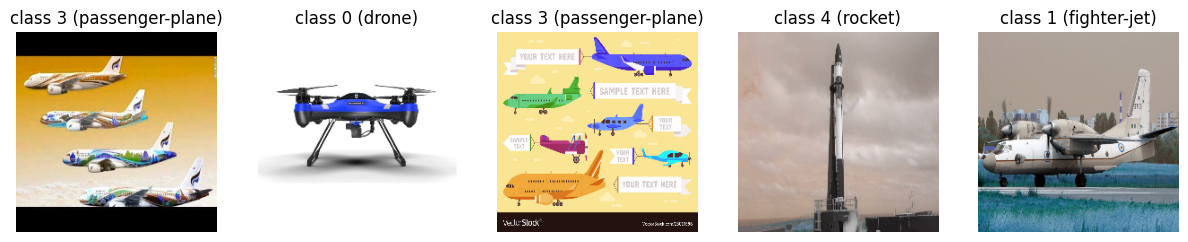

In [ ]:
plt.figure(figsize=(15,5))

for i in range(5):
    class_index = int(y_test[i])  # Cast the value to integer
    class_name = label[class_index]
    plt.subplot(150 + 1 + i).set_title(f'class {class_index} ({class_name})')
    plt.imshow(x_test[i])
    plt.axis('off')  # Hide axis for better visualization

plt.show()


**SELECT MODEL**

In [ ]:
img_w,img_h = 224, 224
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))

vgg_extractor.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

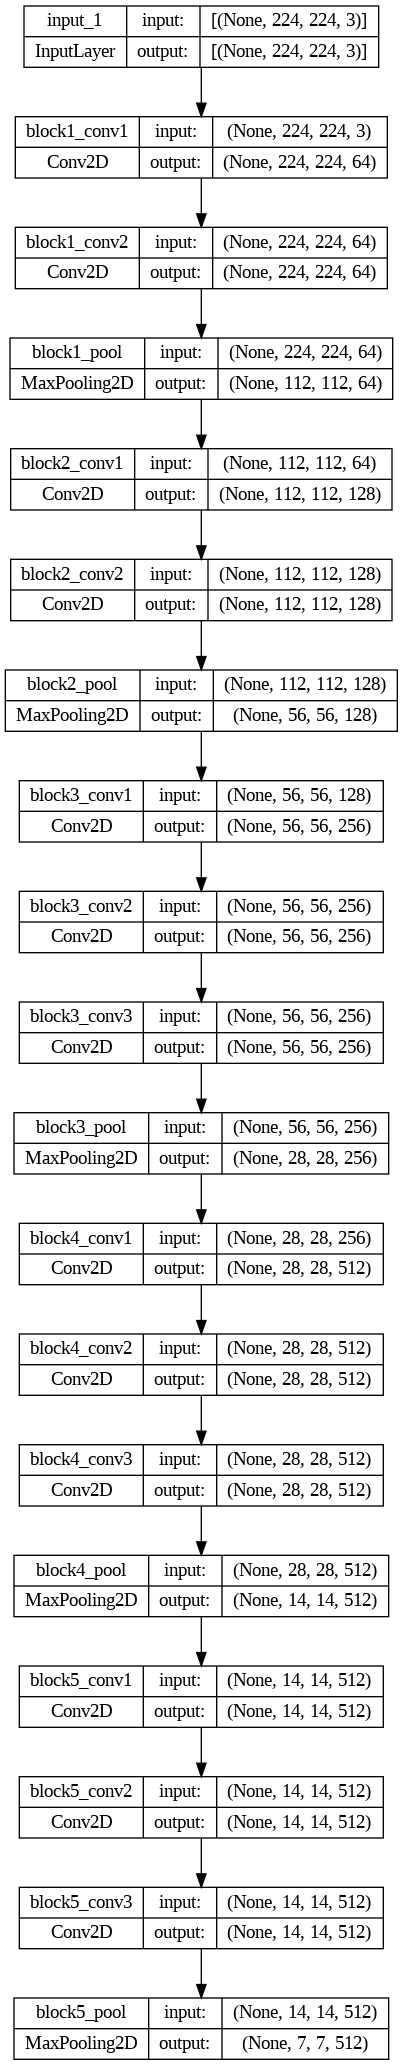

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(vgg_extractor, 'VGG16_Model.png', show_shapes=True,show_layer_names=True)

In [ ]:
#Recursively freeze all layers in the model first
vgg_extractor.trainable = False

for i, layer in enumerate(vgg_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv2, Trainable = False
Layer 3: Name = block1_pool, Trainable = False
Layer 4: Name = block2_conv1, Trainable = False
Layer 5: Name = block2_conv2, Trainable = False
Layer 6: Name = block2_pool, Trainable = False
Layer 7: Name = block3_conv1, Trainable = False
Layer 8: Name = block3_conv2, Trainable = False
Layer 9: Name = block3_conv3, Trainable = False
Layer 10: Name = block3_pool, Trainable = False
Layer 11: Name = block4_conv1, Trainable = False
Layer 12: Name = block4_conv2, Trainable = False
Layer 13: Name = block4_conv3, Trainable = False
Layer 14: Name = block4_pool, Trainable = False
Layer 15: Name = block5_conv1, Trainable = False
Layer 16: Name = block5_conv2, Trainable = False
Layer 17: Name = block5_conv3, Trainable = False
Layer 18: Name = block5_pool, Trainable = False


**FINE-TUNE BY UNFREEZE AT LAYER 17**

In [ ]:
#Access a layer by name
b = vgg_extractor.get_layer('block5_conv3')
c = vgg_extractor.get_layer('block5_conv1')
print(f'Layer {b}: Name = {b.name}, Trainable = {b.trainable}')

b.trainable=True
c.trainable=False

Layer <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cbb200bf5e0>: Name = block5_conv3, Trainable = True


In [ ]:
#Iterate over all layers in the model
for i, layer in enumerate(vgg_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv2, Trainable = False
Layer 3: Name = block1_pool, Trainable = False
Layer 4: Name = block2_conv1, Trainable = False
Layer 5: Name = block2_conv2, Trainable = False
Layer 6: Name = block2_pool, Trainable = False
Layer 7: Name = block3_conv1, Trainable = False
Layer 8: Name = block3_conv2, Trainable = False
Layer 9: Name = block3_conv3, Trainable = False
Layer 10: Name = block3_pool, Trainable = False
Layer 11: Name = block4_conv1, Trainable = False
Layer 12: Name = block4_conv2, Trainable = False
Layer 13: Name = block4_conv3, Trainable = False
Layer 14: Name = block4_pool, Trainable = False
Layer 15: Name = block5_conv1, Trainable = False
Layer 16: Name = block5_conv2, Trainable = False
Layer 17: Name = block5_conv3, Trainable = True
Layer 18: Name = block5_pool, Trainable = False


In [ ]:
#Pre-processing
x_train_vgg =  tf.keras.applications.vgg16.preprocess_input(x_train)
x_test_vgg = tf.keras.applications.vgg16.preprocess_input(x_test)

print(x_train_vgg.shape)
print(x_test_vgg.shape)


(3082, 224, 224, 3)
(771, 224, 224, 3)


**DATA AUGMENT**

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1. / 255,
        #featurewise_center=True,
        samplewise_center=True,
        #featurewise_std_normalization=True,
        samplewise_std_normalization=True,
        #zca_whitening=False,
        rotation_range=0,
        width_shift_range=5.0,
        height_shift_range=5.0,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.3)
train_datagen.fit(x_train_vgg)

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1. / 255,
        # featurewise_center=True,
        samplewise_center=True,
        # featurewise_std_normalization=True,
        samplewise_std_normalization=True
        )
test_datagen.fit(x_test_vgg)

===== Train batch no. 1/1 =====


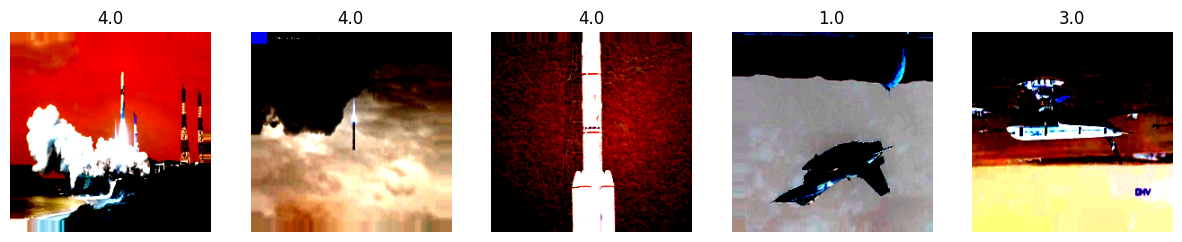

In [ ]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='training' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks
  plt.show()

  if b+1 >= n_show:
    break


===== Train batch no. 1/1 =====


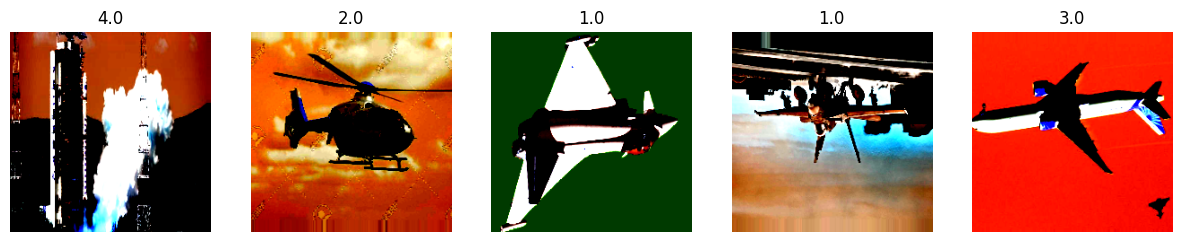

In [ ]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='validation' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks
  plt.show()

  if b+1 >= n_show:
    break

In [ ]:
x = vgg_extractor.output

#Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)

x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)

#construct the main model
model = tf.keras.models.Model(inputs = vgg_extractor.inputs, outputs = new_outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

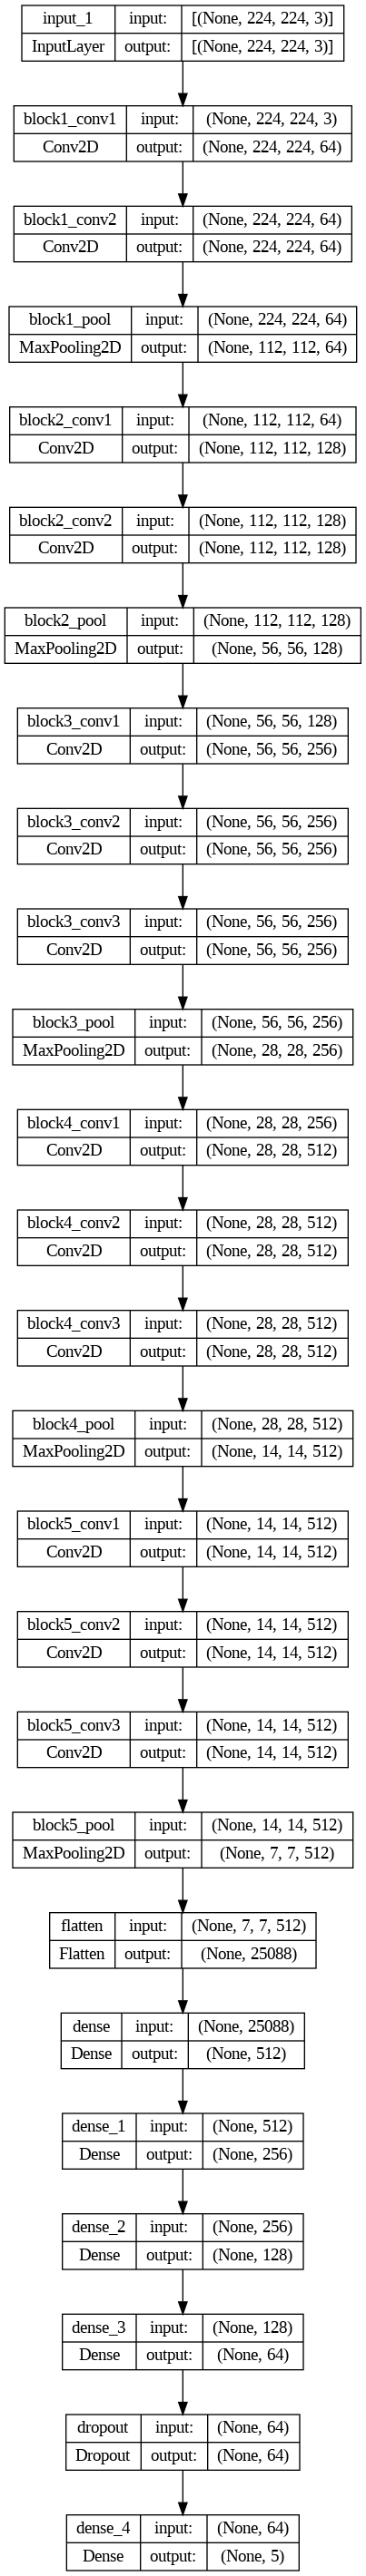

In [ ]:
plot_model(model, 'VGG16_Model_2.png', show_shapes=True,show_layer_names=True)

**TRAIN & MODEL EVALUATE**

In [ ]:
from tensorflow.keras.optimizers import Adam
from traitlets import validate

optimizer = Adam(learning_rate=0.001)

model.compile( loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["acc"] )

In [ ]:
print(y_train.shape)
print(y_train.dtype)


(3082,)
float32


In [ ]:
num_classes = len(np.unique(y_train))
print(num_classes)


5


In [ ]:
y_train[0:10]

array([3., 3., 2., 2., 0., 3., 2., 1., 3., 2.], dtype=float32)

In [ ]:
from wandb.keras import WandbCallback
wandb.init(project='Micky_VGG_Fine_tuning', entity='deep-a')

In [ ]:
history = model.fit(train_datagen.flow(x_train_vgg ,y_train,batch_size=32,subset='training'),epochs = 20, verbose = 1,
                    validation_data=train_datagen.flow(x_train_vgg ,y_train,batch_size=32,subset='validation'),
                    callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
68/68 [==============================] - ETA: 0s - loss: 0.9918 - acc: 0.6353

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231024_072928-m3pqnodd/files/model-best)... Done. 0.6s


68/68 [==============================] - 59s 614ms/step - loss: 0.9918 - acc: 0.6353 - val_loss: 0.5057 - val_acc: 0.8312
Epoch 2/20
68/68 [==============================] - ETA: 0s - loss: 0.5639 - acc: 0.8276

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231024_072928-m3pqnodd/files/model-best)... Done. 1.7s


68/68 [==============================] - 36s 530ms/step - loss: 0.5639 - acc: 0.8276 - val_loss: 0.4305 - val_acc: 0.8582
Epoch 3/20
68/68 [==============================] - 31s 456ms/step - loss: 0.4525 - acc: 0.8642 - val_loss: 0.4538 - val_acc: 0.8658
Epoch 4/20
68/68 [==============================] - ETA: 0s - loss: 0.3575 - acc: 0.8967

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231024_072928-m3pqnodd/files/model-best)... Done. 0.7s


68/68 [==============================] - 35s 514ms/step - loss: 0.3575 - acc: 0.8967 - val_loss: 0.4191 - val_acc: 0.8734
Epoch 5/20
68/68 [==============================] - 30s 446ms/step - loss: 0.3105 - acc: 0.9194 - val_loss: 0.4426 - val_acc: 0.8647
Epoch 6/20
68/68 [==============================] - 31s 462ms/step - loss: 0.2747 - acc: 0.9208 - val_loss: 0.4310 - val_acc: 0.8918
Epoch 7/20
68/68 [==============================] - 32s 465ms/step - loss: 0.2307 - acc: 0.9356 - val_loss: 0.4448 - val_acc: 0.8983
Epoch 8/20
68/68 [==============================] - 32s 464ms/step - loss: 0.2251 - acc: 0.9407 - val_loss: 0.5033 - val_acc: 0.8820
Epoch 9/20
68/68 [==============================] - 31s 458ms/step - loss: 0.1929 - acc: 0.9430 - val_loss: 0.5441 - val_acc: 0.8755
Epoch 10/20
68/68 [==============================] - 31s 460ms/step - loss: 0.1614 - acc: 0.9486 - val_loss: 0.6101 - val_acc: 0.8755
Epoch 11/20
68/68 [==============================] - 31s 457ms/step - loss: 0.2

In [ ]:
wandb.finish()

acc,▁▅▆▆▇▇▇▇▇▇▇█▇███████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
val_acc,▁▃▄▄▄▆▇▅▅▅▇▆█▄▅▆█▇▇▆
val_loss,▃▁▂▁▂▁▂▃▄▅▃▃▄▇▃▅▃▇█▅
acc,0.96942
best_epoch,3
best_val_loss,0.41912
epoch,19
loss,0.13813
val_acc,0.89286


In [ ]:
results = model.evaluate(test_datagen.flow(x_test_vgg, y_test, batch_size = 128))
print(f'{model.metrics_names}: {results}')

7/7 [==============================] - 21s 625ms/step - loss: 0.5083 - acc: 0.9066
['loss', 'acc']: [0.508325457572937, 0.9066147804260254]


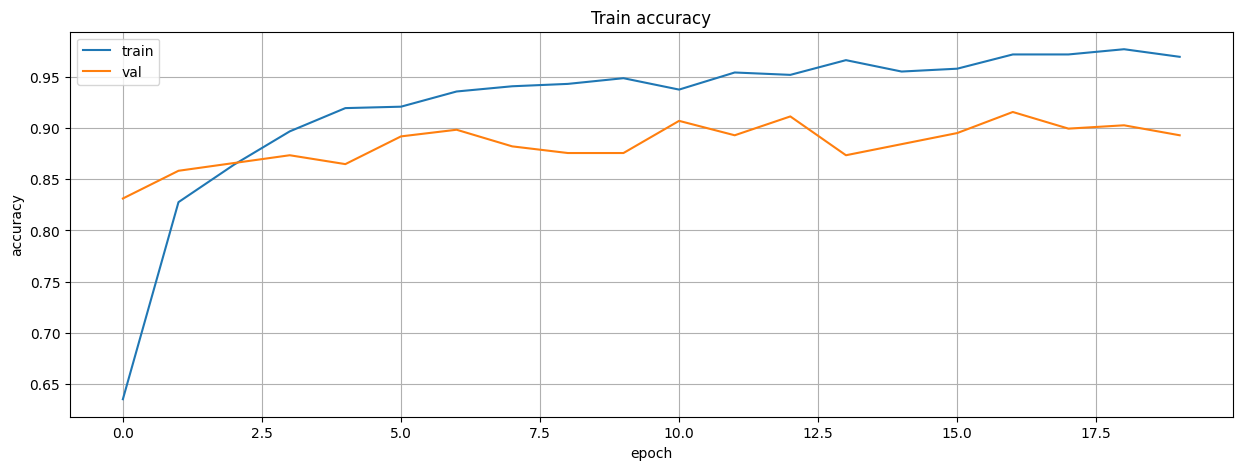

In [ ]:
#Summarize history of accuracy
plt.figure(figsize = (15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

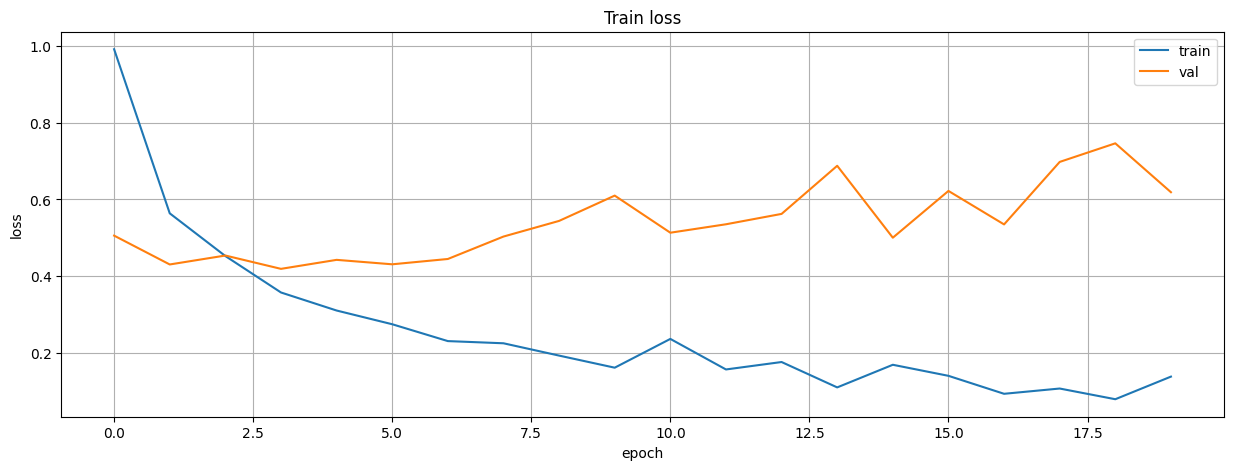

In [ ]:
#Summarize history for loss
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

In [ ]:
plt.rcParams["axes.linewidth"] = 5

def color_frame( ax, y_true, y_pred ):
  color = 'green' if (y_true == y_pred) else 'red'
  ax.spines['bottom'].set_color(color)
  ax.spines['top'].set_color(color)
  ax.spines['right'].set_color(color)
  ax.spines['left'].set_color(color)

samples.shape=(10, 224, 224, 3)
1/1 [==============================] - 2s 2s/step


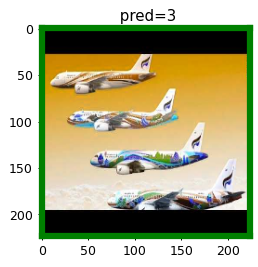

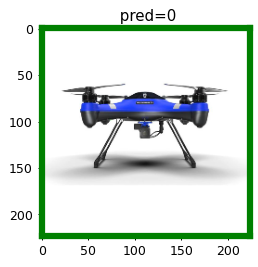

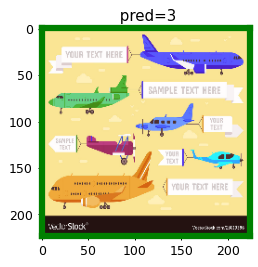

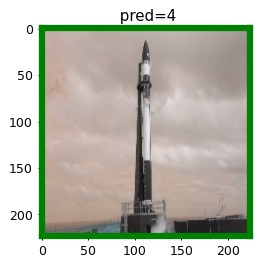

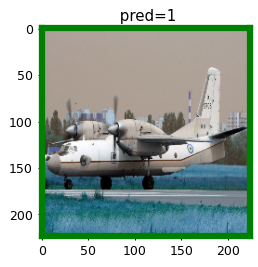

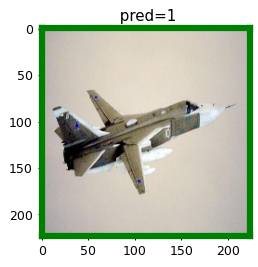

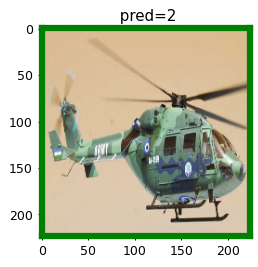

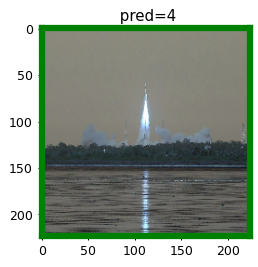

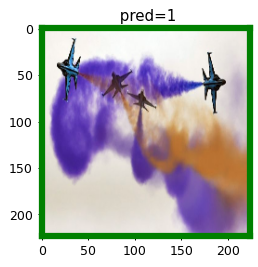

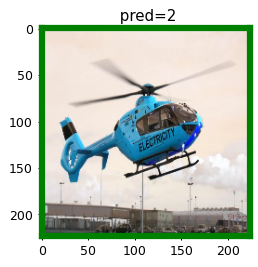

In [ ]:
# Test using the model on many images


# Get a batch of samples
n = 10
samples = x_test[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Interpret the results
for i in range(n):
  plt.figure(figsize=(3,3), dpi=90)
  ax = plt.gca()
  plt.imshow( x_test[i] )
  plt.title(f" pred={np.argmax(y_pred[i])}")
  color_frame(ax, y_test[i], np.argmax(y_pred[i]))
  plt.show()

**GRAD-CAM**

In [ ]:
import keras

img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
last_conv_layer_name = "block5_pool"

1/1 [==============================] - 1s 748ms/step
Predicted: helicopter | Actual: helicopter 


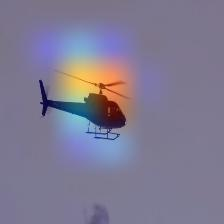

1/1 [==============================] - 0s 18ms/step
Predicted: helicopter | Actual: helicopter 


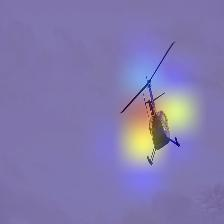

1/1 [==============================] - 0s 18ms/step
Predicted: rocket | Actual: rocket 


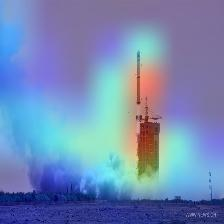

1/1 [==============================] - 0s 18ms/step
Predicted: drone | Actual: drone 


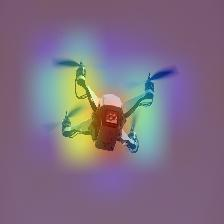

1/1 [==============================] - 0s 17ms/step
Predicted: fighter-jet | Actual: drone 


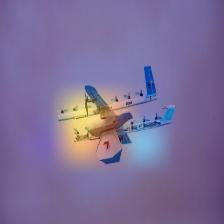

In [ ]:
from IPython.display import Image, display
import matplotlib.cm as cmp


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = plt.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)

      # Display Grad CAM
      display(Image(cam_path))

for i in range(5):
  c= np.random.randint(0,180)
  img_path = x_test[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,224,224,3))
  print(f"Predicted: {label[int(np.argmax(preds))]} | Actual: {label[int(y_test[c])]} ")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)